## DRSA : Deep Recurrent Survival Analysis
- paper : https://arxiv.org/pdf/1809.02403.pdf

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [2]:
from drsa.model import DRSA
import torch
import torch.nn as nn
import torch.optim as optim
import pycox.datasets as dt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
from torch.utils.data import Dataset
from pycox.preprocessing import label_transforms
import matplotlib.pyplot as plt

In [3]:
# for deterministic results
seed = 1234

np.random.seed(seed)
_ = torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU

## Dataset Class

In [4]:
class DRSA_Dataset(Dataset):
    def __init__(self, name, phase='train'):
        super().__init__()
        if name == 'support':
            cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
            cols_leave = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
            max_seq_len = 20 # will be modified
        elif name == 'metabric':
            cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
            cols_leave = ['x4', 'x5', 'x6', 'x7']
            max_seq_len = 20 # will be modified
        else:
            raise NotImplementedError
                        
        self.max_seq_len = max_seq_len
        self.cols_standardize = cols_standardize
        self.cols_leave = cols_leave
        
        cols_tgt = ['duration', 'event']
        
        # Split train/val/test
        df_full = eval(f'dt.{name}.read_df()')
        df_test = df_full.sample(frac=0.2)
        df_train = df_full.drop(df_test.index)
        df_val = df_train.sample(frac=0.2)
        df_train = df_train.drop(df_val.index)
        
        # Target info
        y_train = df_train[cols_tgt].values
        y_val = df_val[cols_tgt].values
        y_test = df_test[cols_tgt].values
        
        # Target label preprocessing (duration -> duration_idxs)
        target_parse_fn = DRSA_Dataset.get_target
        labtrans = label_transforms.LabTransDiscreteTime(max_seq_len)
        y_train  = np.c_[labtrans.fit_transform(*target_parse_fn(y_train))]
        y_val    = np.c_[labtrans.transform(*target_parse_fn(y_val))]
        
        # Input Covariates
        df_train = df_train.drop(cols_tgt, axis=1)
        df_val = df_val.drop(cols_tgt, axis=1)
        df_test = df_test.drop(cols_tgt, axis=1)
        
        # Input data preprocessing
        standardize = [([col], StandardScaler()) for col in cols_standardize]
        leave = [(col, None) for col in cols_leave]
        
        # assume categorical columns located first (for embedding later)
        x_mapper = DataFrameMapper(leave + standardize)
        x_train = x_mapper.fit_transform(df_train).astype('float32')
        x_val = x_mapper.transform(df_val).astype('float32')
        x_test = x_mapper.transform(df_test).astype('float32')
        
        if phase == 'train':
            self.X, self.Y = x_train, y_train
        if phase == 'val':
            self.X, self.Y = x_val, y_val
        if phase == 'test':
            self.X, self.Y = x_test, y_test
        
        setattr(self, 'labtrans', labtrans)
                    
    @property
    def numeric_columns(self):
        return self.cols_standardize
    
    @property
    def categorical_columns(self):
        return self.cols_leave
    
    @property
    def n_features(self):
        return self.X.shape[1]
    
    @property
    def n_embeddings(self):
        return [ len(np.unique(self.X[:, ix])) for ix in range(len(self.categorical_columns)) ]
    
    @staticmethod
    def get_target(y):
        durations, events = y.T
        return durations, events
        
    def __getitem__(self, ix):
        x = torch.from_numpy(self.X[ix])
        y = torch.from_numpy(self.Y[ix])
        
        # Add time features on tiled covariates
        xs = x.tile(self.max_seq_len, 1)
        t = torch.arange(self.max_seq_len).unsqueeze(1) / self.max_seq_len
        xs = torch.cat((xs, t), dim=1)
        
        return xs, y
    
    def __len__(self):
        return len(self.X)

## Dataloaders

In [5]:
from torch.utils.data import DataLoader

name = 'metabric' # name of dataset
batch_size = 256

train_ds = DRSA_Dataset(name, 'train')
val_ds = DRSA_Dataset(name, 'val')
test_ds = DRSA_Dataset(name, 'test')

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

## instantiating embedding parameters

In [6]:
if not torch.backends.mps.is_available():
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
else:
    device = torch.device("mps")

In [7]:
device

device(type='mps')

In [9]:
embedding_size = 50

def get_embeddings(n_embeddings):
    layers = []
    for nb_emb in n_embeddings:
        emb = torch.nn.Embedding(nb_emb, embedding_size, device=device)
        emb.weight.data.uniform_(-0.1, 0.1)
        layers.append(emb)
    return layers
    
embeddings = get_embeddings(train_ds.n_embeddings)

## instantiating model

In [10]:
import pandas as pd
import torchtuples as tt
from pycox import models
from pycox.models.utils import pad_col
from pycox.models.interpolation import InterpolateLogisticHazard
from pycox.evaluation.concordance import concordance_td
from pycox import utils

In [11]:
class PyCoxWrapper(tt.Model):
    """Wrapper class for pycox API compatibility
    """
    _steps ='post'
    
    def __init__(self, net, loss=None, optimizer=None, device=None, duration_index=None):
        
        self.duration_index = duration_index
        super().__init__(net, loss, optimizer, device)

    @property
    def duration_index(self):
        """
        Array of durations that defines the discrete times. This is used to set the index
        of the DataFrame in `predict_surv_df`.
        
        Returns:
            np.array -- Duration index.
        """
        return self._duration_index

    @duration_index.setter
    def duration_index(self, val):
        self._duration_index = val
    
    def predict_surv(self, input, batch_size=8224, numpy=None, eval_=True, to_cpu=False,
                     num_workers=0):
        #pmf = self.predict_pmf(input, batch_size, False, eval_, to_cpu, num_workers)
        preds = self.predict(input, batch_size, False, eval_, False, to_cpu, num_workers)
        preds = pad_col(preds[..., 0])[:, :-1]
        #surv = (1-preds).cumprod(1)
        #surv = 1 - preds.cumsum(1)
        surv = (1 - preds).add(1e-7).log().cumsum(1).exp()
        return tt.utils.array_or_tensor(surv, numpy, input)

    def predict_pmf(self, input, batch_size=8224, numpy=None, eval_=True, to_cpu=False,
                    num_workers=0):
        preds = self.predict(input, batch_size, False, eval_, False, to_cpu, num_workers)
        pmf = pad_col(preds[..., 0])[:, :-1]
        return tt.utils.array_or_tensor(pmf, numpy, input)

    def predict_surv_df(self, input, batch_size=8224, eval_=True, num_workers=0):
        surv = self.predict_surv(input, batch_size, True, eval_, True, num_workers)
        return pd.DataFrame(surv.transpose(), self.duration_index)

    def interpolate(self, sub=10, scheme='const_pdf', duration_index=None):
        """Use interpolation for predictions.
        There are only one scheme:
            `const_pdf` and `lin_surv` which assumes pice-wise constant pmf in each interval (linear survival).
        
        Keyword Arguments:
            sub {int} -- Number of "sub" units in interpolation grid. If `sub` is 10 we have a grid with
                10 times the number of grid points than the original `duration_index` (default: {10}).
            scheme {str} -- Type of interpolation {'const_hazard', 'const_pdf'}.
                See `InterpolateDiscrete` (default: {'const_pdf'})
            duration_index {np.array} -- Cuts used for discretization. Does not affect interpolation,
                only for setting index in `predict_surv_df` (default: {None})
        
        Returns:
            [InterpolationPMF] -- Object for prediction with interpolation.
        """
        if duration_index is None:
            duration_index = self.duration_index
        return InterpolateLogisticHazard(self, scheme, duration_index, sub)

In [12]:
net = DRSA(
    n_features=train_ds.n_features+1,  # +1 for time features
    hidden_dim=64,
    n_layers=1,
    embeddings=embeddings,
)
net.to(device)

DRSA(
  (lstm): LSTM(206, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (linear_dropout): Dropout(p=0.0, inplace=False)
  (sigmoid): Sigmoid()
  (params_to_train): ModuleList(
    (0): Embedding(2, 50)
    (1): Embedding(2, 50)
    (2): Embedding(2, 50)
    (3): Embedding(2, 50)
  )
)

In [13]:
from drsa.functions import event_time_loss, log_event_rate, log_survival_rate
from pycox.models.loss import nll_logistic_hazard

class LossDRSA(nn.Module):
    def __init__(self, alpha=0.3):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), 'Need `alpha` in [0, 1].'
        self.alpha = alpha

    def forward(self, preds, target=None):
        idx_durations, events = target.T
        
        L_z = event_time_loss(preds)
        
        c = 1.0 - events
        log_St = log_survival_rate(preds).squeeze()
        log_Wt = log_event_rate(preds).squeeze()
        L_c = -(c*log_St+(1-c)*log_Wt).mean(dim=0).squeeze()
        
        
        def inverse_sigmoid(y):
            return torch.log(y / (1 - y))

        nll_loss = nll_logistic_hazard(inverse_sigmoid(preds[..., 0]), idx_durations.long(), events.float())
        
        # weighted average of L_z and L_c
        loss = (self.alpha * L_z) + ((1 - self.alpha) * L_c)
        loss += nll_loss
        return loss    

In [14]:
labtrans = train_ds.labtrans
optimizer = tt.optim.Adam(lr=1e-3)
model = PyCoxWrapper(net, LossDRSA(), optimizer, 
                     duration_index=labtrans.cuts)

In [15]:
callbacks = [tt.callbacks.EarlyStopping()]

log = model.fit_dataloader(train_loader, 
                           epochs=3000, 
                           callbacks=callbacks,
                           val_dataloader=val_loader)

0:	[0s / 0s],		train_loss: 12.7209,	val_loss: 11.1434
1:	[0s / 0s],		train_loss: 10.6248,	val_loss: 8.9011
2:	[0s / 0s],		train_loss: 8.0438,	val_loss: 6.0542
3:	[0s / 1s],		train_loss: 5.1703,	val_loss: 3.9407
4:	[0s / 1s],		train_loss: 3.7412,	val_loss: 3.8544
5:	[0s / 1s],		train_loss: 3.7939,	val_loss: 4.0428
6:	[0s / 1s],		train_loss: 3.8278,	val_loss: 3.9324
7:	[0s / 1s],		train_loss: 3.6797,	val_loss: 3.7519
8:	[0s / 2s],		train_loss: 3.5547,	val_loss: 3.6455
9:	[0s / 2s],		train_loss: 3.5022,	val_loss: 3.6120
10:	[0s / 2s],		train_loss: 3.4947,	val_loss: 3.5980
11:	[0s / 2s],		train_loss: 3.4875,	val_loss: 3.5827
12:	[0s / 3s],		train_loss: 3.4641,	val_loss: 3.5736
13:	[0s / 3s],		train_loss: 3.4493,	val_loss: 3.5705
14:	[0s / 3s],		train_loss: 3.4382,	val_loss: 3.5669
15:	[0s / 3s],		train_loss: 3.4395,	val_loss: 3.5595
16:	[0s / 4s],		train_loss: 3.4182,	val_loss: 3.5466
17:	[0s / 4s],		train_loss: 3.4101,	val_loss: 3.5356
18:	[0s / 4s],		train_loss: 3.4009,	val_loss: 3.5269


<Axes: >

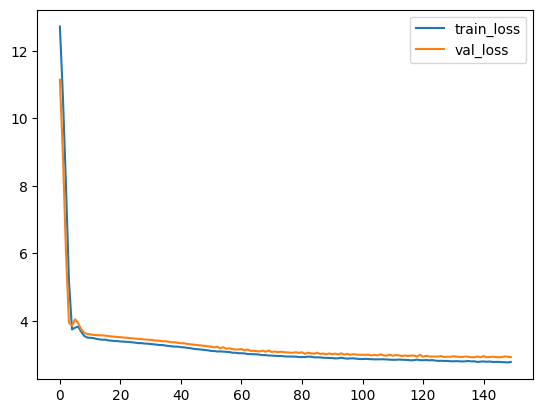

In [16]:
log.plot()

## Evaluation

In [17]:
x_test = []
y_test = []

for x,y in test_ds:
    x_test.append(x.numpy())
    y_test.append(y.numpy())
    
x_test = np.array(x_test)
y_test = np.array(y_test)

durations_test, events_test = y_test.T

In [18]:
surv = model.interpolate(100).predict_surv_df(x_test)

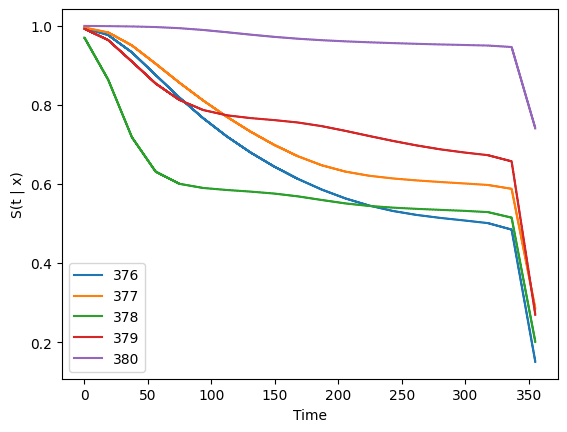

In [19]:
surv.iloc[:, -5:].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
durations_test[-5:], events_test[-5:]

(array([187.8666687 ,  57.66666794, 213.8999939 ,  51.        ,
        111.69999695]),
 array([1., 1., 0., 1., 1.]))

## Evaluation

In [21]:
from pycox.evaluation import EvalSurv

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/Users/yuhosang/Projects/deep-dialysis.pytorch/venv/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [22]:
ev.concordance_td('antolini')

0.6719841476351555

In [ ]:
!rm *.pt

In [ ]:
# support : 0.6967800877342815 (test: 0.3, valid: 0.1)
# 0.7339499777570538 (test: 0.2, valid: 0.2)

# metabric : 0.6951326831481062 (test: 0.3, valid: 0.1)
# 0.6719841476351555 (test: 0.2, valid: 0.2)